# Instance Segmentation
The data will be downloaded on its own in the folder by running the code. The explanation of the network architecture is given a few cells below. Recommendable to use a large memory GPU, cause its a bit resource intensive

In [ ]:
# Importing the libraries
import torch
import numpy as np
import os
from PIL import Image
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.pyplot as plt

In [ ]:
# Downloading the data
import requests
url = "https://drive.usercontent.google.com/download?id=11s-GLb6LZ0SCAVW6aikqImuuQEEbT_Fb&export=download&authuser=0&confirm=t&uuid=06441732-816f-4b3a-b284-4897f70a02bf&at=AIrpjvOo0YFFecabv8HdryhjE7xj%3A1738360908392"

response = requests.get(url)
file_Path = 'dl_challenge.tar.xz'

if response.status_code == 200:
    with open(file_Path, 'wb') as file:
        file.write(response.content)
    print('File downloaded successfully')
else:
    print('Failed to download file')

File downloaded successfully


In [ ]:
# Export the tarfile
import tarfile

with tarfile.open('dl_challenge.tar.xz') as f:
    f.extractall('.')

In [ ]:
# The function takes in the path of the folder, and extracts the data into lists
def Extractor(name="./dl_challenge/"):
    folders = os.listdir(name)

    images=[]
    masks=[]
    bboxes=[]
    pcs=[]

    for folder in folders:
        for dirpath, _ , filenames in os.walk(os.path.join("./dl_challenge",folder)):
            for filename in filenames:
                if filename.endswith('.jpg'):
                    image_path=os.path.join(dirpath,filename)
                    image= Image.open(image_path)
                    images.append(image)
                if filename.startswith('mask'):
                    mask_path=os.path.join(dirpath,filename)
                    mask= np.load(mask_path)
                    masks.append(mask)
                if filename.startswith('bbox3d'):
                    bbox_path=os.path.join(dirpath,filename)
                    bbox= np.load(bbox_path)
                    bboxes.append(bbox)
                if filename.startswith('pc'):
                    pc_path=os.path.join(dirpath,filename)
                    pc= np.load(pc_path)
                    pcs.append(pc)

    return images,masks,bboxes,pcs

In [ ]:
# As we have no labels so the labels would be all ones. Basically 2 labels: 0 is background, 1 is object
images,masks,bboxes,pcs=Extractor()
labels = []
for mask in masks:
    labels.append(np.ones(mask.shape[0], dtype=np.int64))


In [ ]:
# We have to first convert the 3d bounding boxes to 2d
def convert_3d_bbox_to_2d(bboxes_3d):
    xmin = torch.min(bboxes_3d[:, :, 0], dim=1)[0]
    ymin = torch.min(bboxes_3d[:, :, 1], dim=1)[0]
    xmax = torch.max(bboxes_3d[:, :, 0], dim=1)[0]
    ymax = torch.max(bboxes_3d[:, :, 1], dim=1)[0]
    bboxes_2d = torch.stack([xmin, ymin, xmax, ymax], dim=1)

    return bboxes_2d

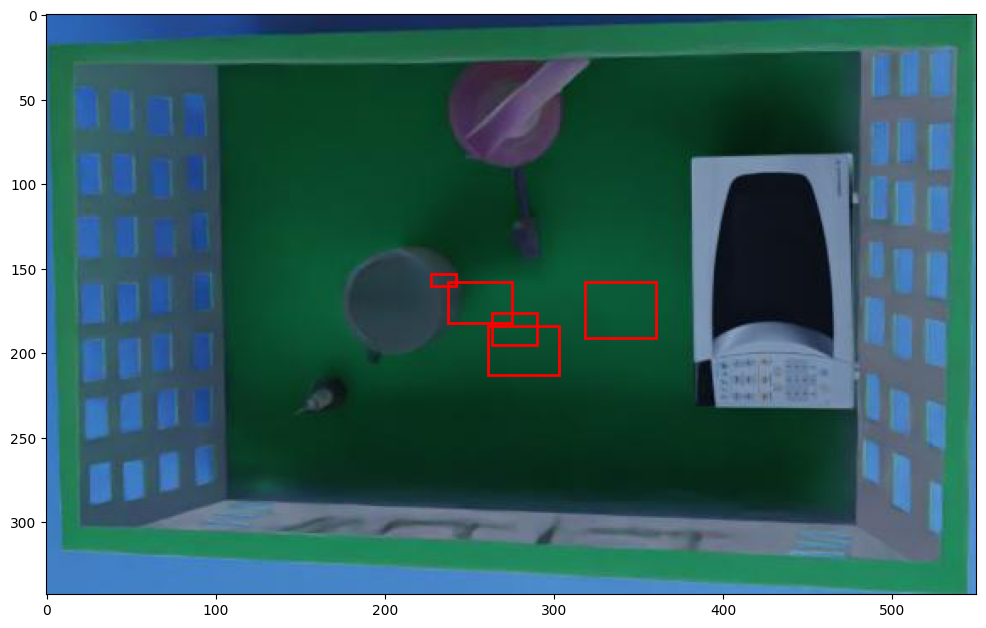

In [ ]:
# Checking if the bounding boxes match the images, we are just going to make boxes and put it on image
bboxes_image = bboxes[0]
bboxes_tensor = torch.tensor(bboxes_image)
bboxes_2d = convert_3d_bbox_to_2d(bboxes_tensor)
img_np = np.array(images[0])
plt.figure(figsize=(12, 8))
plt.imshow(img_np)

# Draw the 2D bounding boxes
for bbox in bboxes_2d:
    xmin, ymin, xmax, ymax = bbox.numpy()
    x1_px = int((xmin + 1) * img_np.shape[1] / 2)
    y1_px = int((-ymin + 1) * img_np.shape[0] / 2)
    x2_px = int((xmax + 1) * img_np.shape[1] / 2)
    y2_px = int((-ymax + 1) * img_np.shape[0] / 2)

    rect = plt.Rectangle(
        (x1_px, y1_px),
        x2_px - x1_px,
        y2_px - y1_px,
        fill=False,
        color='red',
        linewidth=2
    )
    plt.gca().add_patch(rect)

plt.axis('on')
plt.show()

Apparently above the Bounding box do not match with the objects, but it looks like the number of boxes in the image match up with the number of objects. We would also want to see the masks on the image

In [ ]:
# Get the first image and its corresponding mask
mask = masks[0]  # Assuming masks is a list of masks for each image

# Print the shape of the mask
print("Mask shape:", mask.shape)

Mask shape: (5, 343, 550)


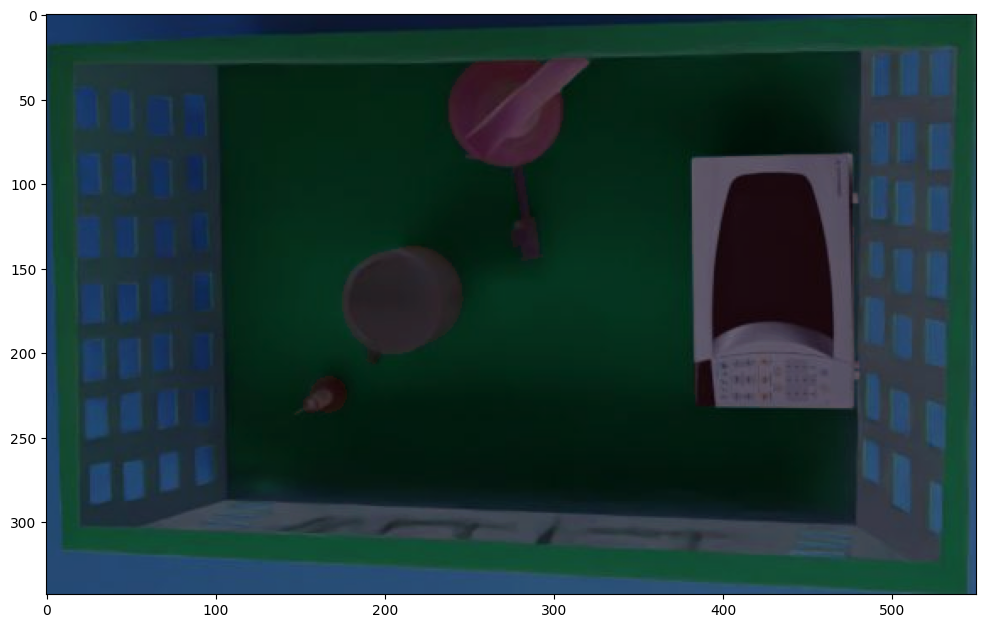

In [ ]:
img_np = np.array(images[0])
mask = masks[0]
plt.figure(figsize=(12, 8))
plt.imshow(img_np)

for i in range(mask.shape[0]):
    mask_sel = mask[i]
    # print(mask_sel.shape)
    colored_mask = np.zeros((mask_sel.shape[0], mask_sel.shape[1], 3), dtype=np.uint8)
    colored_mask[mask_sel == 1] = [255, 0, 0]
    plt.imshow(colored_mask, alpha=0.1)

plt.axis('on')
plt.show()

The mask is correctly outputted on image

In [ ]:
# We now define a class for dataloader purposes.
import torch.utils
import torch.utils.data
import torch.utils.data.dataset

class DataLoad(torch.utils.data.dataset.Dataset):
    def __init__(self, images, masks, bboxes, labels):
        self.images = images
        self.masks = masks
        self.bboxes = bboxes
        self.labels = labels

    def __getitem__(self,idx):
        data = {}
        transform= T.ToTensor()
        image = transform(self.images[idx])

        data["masks"] = torch.as_tensor(self.masks[idx],dtype=torch.uint8)
        data["boxes"] = torch.as_tensor(self.bboxes[idx], dtype = torch.float32)
        data["boxes"] = convert_3d_bbox_to_2d(data["boxes"])
        data["labels"] = torch.as_tensor(self.labels[idx],dtype=torch.int64)
        return image, data

    def __len__(self):
        return len(self.images)


The model that we are going to use is MASKRCNN with FAST RCNN. FAST RCNN Model is for object detection, it generates bounding boxes around images, while the MASK RCNN predicts segmentation masks on the regon of interests, this would give us the instance segmetation of the image. The Mask RCNN builds up on the FAST RCNN model architecture by adding a mask prediction branch. The paper makes more inference on the scope of the network: https://arxiv.org/pdf/1703.06870.


From their paper we made the observation about the architecture: Mask R-CNN detects and segments objects in images by combining two main components: the backbone and the network head.

The backbone acts 'like the brain of the system', extracting important features from the entire image. It can utilize architectures like ResNet or ResNeXt, which come in different depths. For even better performance, Mask R-CNN can employ a Feature Pyramid Network (FPN), which 'creates a pyramid of features that helps the model understand objects at various sizes'.

Once the backbone has done its job, the network head takes over, focusing on specific areas of the image where objects are to be found, known as Regions of Interest (RoIs). This part of the architecture is responsible for recognizing the objects by determining their bounding boxes and classifying them, while also predicting masks. Overall, this combination allows Mask R-CNN to be used in tasks like instance segmentation.

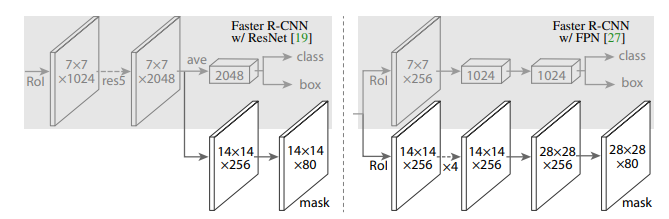

In [ ]:
# We also define our model here
model = torchvision.models.detection.maskrcnn_resnet50_fpn()
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, 2)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


In [ ]:
# We split our data in two parts, train and test
num = int(0.9 * len(images))
num = num if num % 2 == 0 else num + 1
train_imgs_inds = np.random.choice(range(len(images)) , num , replace = False)
test_imgs_inds = np.setdiff1d(range(len(images)) , train_imgs_inds)
train_imgs = np.array(images,dtype="object")[train_imgs_inds]
test_imgs = np.array(images,dtype="object")[test_imgs_inds]
train_masks = np.array(masks,dtype="object")[train_imgs_inds]
test_masks = np.array(masks,dtype="object")[test_imgs_inds]
train_bboxes = np.array(bboxes,dtype="object")[train_imgs_inds]
test_bboxes = np.array(bboxes,dtype="object")[test_imgs_inds]
train_labels = np.array(labels,dtype="object")[train_imgs_inds]
test_labels = np.array(labels,dtype="object")[test_imgs_inds]

In [ ]:
def custom_collate(data):
  return data

In [ ]:
# And we make the data loaders, train and test (val)
train_dl = torch.utils.data.DataLoader(DataLoad(train_imgs , train_masks,train_bboxes,train_labels) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)
val_dl = torch.utils.data.DataLoader(DataLoad(test_imgs , test_masks,test_bboxes,test_labels) ,
                                 batch_size = 2 ,
                                 shuffle = True ,
                                 collate_fn = custom_collate ,
                                 num_workers = 1 ,
                                 pin_memory = True if torch.cuda.is_available() else False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]

In [ ]:
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
print(np.__version__)

1.26.4


In [ ]:
# os.environ['CUDA_LAUNCH_BLOCKING']='1'
# os.environ['TORCH_USE_CUDA_DSA']='1'

Epoch [1/30], Batch [0/90], Loss: 3.060453176498413
Epoch [1/30], Batch [10/90], Loss: 1.4611971378326416
Epoch [1/30], Batch [20/90], Loss: 1.0220812559127808
Epoch [1/30], Batch [30/90], Loss: 0.6676114201545715
Epoch [1/30], Batch [40/90], Loss: 0.30570054054260254
Epoch [1/30], Batch [50/90], Loss: 0.39315956830978394
Epoch [1/30], Batch [60/90], Loss: 0.30057770013809204
Epoch [1/30], Batch [70/90], Loss: 0.0649343729019165
Epoch [1/30], Batch [80/90], Loss: 0.12650161981582642
Epoch [1/30]
Training Loss: 0.6321215233869023
Validation Loss: 0.17902785688638687
Learning Rate: 0.005
-------------------------------------------------
Epoch [2/30], Batch [0/90], Loss: 0.20450574159622192
Epoch [2/30], Batch [10/90], Loss: 0.06717293709516525
Epoch [2/30], Batch [20/90], Loss: 0.06957424432039261
Epoch [2/30], Batch [30/90], Loss: 0.07137393206357956
Epoch [2/30], Batch [40/90], Loss: 0.18323084712028503
Epoch [2/30], Batch [50/90], Loss: 0.15819299221038818
Epoch [2/30], Batch [60/90],

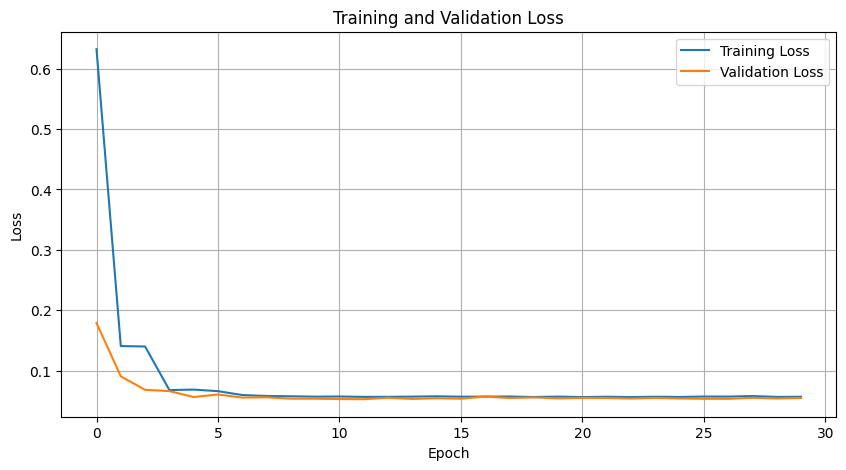

In [ ]:
all_train_losses = []
all_val_losses = []
best_loss = float('inf')
num_epochs = 30

for epoch in range(num_epochs):
    # This is the training loop
    model.train()
    train_epoch_loss = 0
    for i, dt in enumerate(train_dl):
        optimizer.zero_grad()
        imgs = [dt[0][0].to(device), dt[1][0].to(device)]
        targ = [dt[0][1], dt[1][1]]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
        loss_dict = model(imgs, targets)
        losses = sum([l for l in loss_dict.values()])

        losses.backward()
        optimizer.step()
        train_epoch_loss += losses.item()

        if i % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i}/{len(train_dl)}], 'f'Loss: {losses.item()}')

    avg_train_loss = train_epoch_loss / len(train_dl)
    all_train_losses.append(avg_train_loss)

    # And this is the test loop
    # model.eval
    val_epoch_loss = 0
    with torch.no_grad():
        for j, dt in enumerate(val_dl):
            imgs = [dt[0][0].to(device), dt[1][0].to(device)]
            targ = [dt[0][1], dt[1][1]]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss_dict = model(imgs, targets)
            # print(loss_dict)
            losses = sum([l for l in loss_dict.values()])

            val_epoch_loss += losses.item()

    avg_val_loss = val_epoch_loss / len(val_dl)
    all_val_losses.append(avg_val_loss)

    lr_scheduler.step()

    # We check which one gives the best loss and save that one
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, 'best_model.pth')

    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {avg_train_loss}')
    print(f'Validation Loss: {avg_val_loss}')
    print(f'Learning Rate: {optimizer.param_groups[0]["lr"]}')
    print('-------------------------------------------------')

plt.figure(figsize=(10, 5))
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

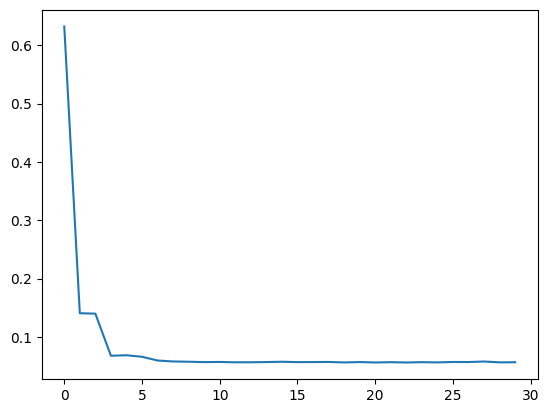

In [ ]:
plt.plot(all_train_losses)

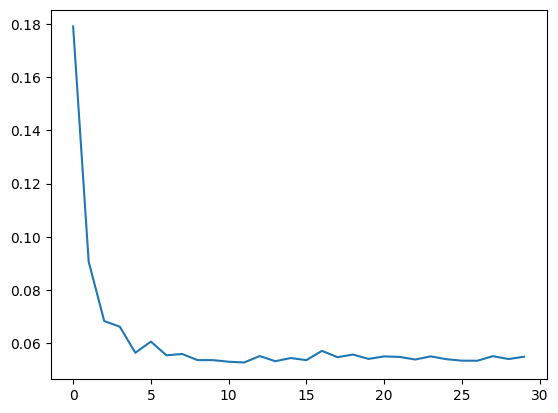

In [ ]:
plt.plot(all_val_losses)

Now we check if the model works, we get an image from the test set

In [ ]:
# Precisely image 2
img_for_test=None
i=0
for j,dt in enumerate(val_dl):
  img_for_test= dt[0][0].to(device)
  i+=1
  if(i==2):
    break
img_for_test

tensor([[[0.4471, 0.4196, 0.4235,  ..., 0.4157, 0.4157, 0.4196],
         [0.4392, 0.4353, 0.4314,  ..., 0.4118, 0.4157, 0.4157],
         [0.4314, 0.4392, 0.4392,  ..., 0.4118, 0.4118, 0.4118],
         ...,
         [0.4353, 0.4314, 0.4235,  ..., 0.3922, 0.4000, 0.4118],
         [0.4275, 0.4196, 0.4196,  ..., 0.4078, 0.4118, 0.4235],
         [0.4196, 0.4196, 0.4196,  ..., 0.4196, 0.4235, 0.4314]],

        [[0.3804, 0.3569, 0.3608,  ..., 0.3765, 0.3765, 0.3804],
         [0.3725, 0.3725, 0.3804,  ..., 0.3725, 0.3765, 0.3765],
         [0.3686, 0.3882, 0.3922,  ..., 0.3725, 0.3725, 0.3725],
         ...,
         [0.3922, 0.3882, 0.3725,  ..., 0.3294, 0.3373, 0.3490],
         [0.3961, 0.3882, 0.3725,  ..., 0.3451, 0.3490, 0.3608],
         [0.3882, 0.3882, 0.3725,  ..., 0.3569, 0.3608, 0.3686]],

        [[0.3176, 0.2941, 0.3020,  ..., 0.3373, 0.3373, 0.3412],
         [0.3098, 0.3098, 0.3176,  ..., 0.3333, 0.3373, 0.3373],
         [0.3059, 0.3216, 0.3294,  ..., 0.3333, 0.3333, 0.

In [ ]:
# We get the prediction from the model
model.eval()
with torch.no_grad():
    pred = model([img_for_test.to(device)])

In [ ]:
pred

[{'boxes': tensor([[3.2246e-05, 0.0000e+00, 6.0595e-02, 5.3652e-02],
          [6.5229e-05, 0.0000e+00, 1.2257e-01, 6.3810e-02],
          [2.9155e-05, 4.8990e-04, 5.4609e-02, 1.8917e-01],
          [4.1042e-05, 4.8295e-02, 5.9576e-02, 2.7376e-01],
          [6.5849e-05, 1.1368e-01, 7.2567e-02, 3.3086e-01],
          [1.3135e-01, 1.1601e-01, 3.4237e-01, 3.2199e-01],
          [2.1646e-01, 2.1162e-01, 4.3539e-01, 4.1966e-01],
          [9.5039e-02, 4.9885e-01, 3.1588e-01, 7.0914e-01],
          [3.4599e-01, 3.6135e-01, 5.7028e-01, 5.7795e-01],
          [2.9815e-02, 1.4630e+00, 2.3952e-01, 1.6643e+00],
          [1.3257e-03, 1.6255e+00, 1.8518e-01, 1.8303e+00]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.8125, 0.8125, 0.8122, 0.7870, 0.7492, 0.6577, 0.5123, 0.3878, 0.2909,
          0.0703, 0.0618], device='cuda:0'),
  'masks': tensor([[[[5.2555e-21, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
             0.0000e+00, 0.

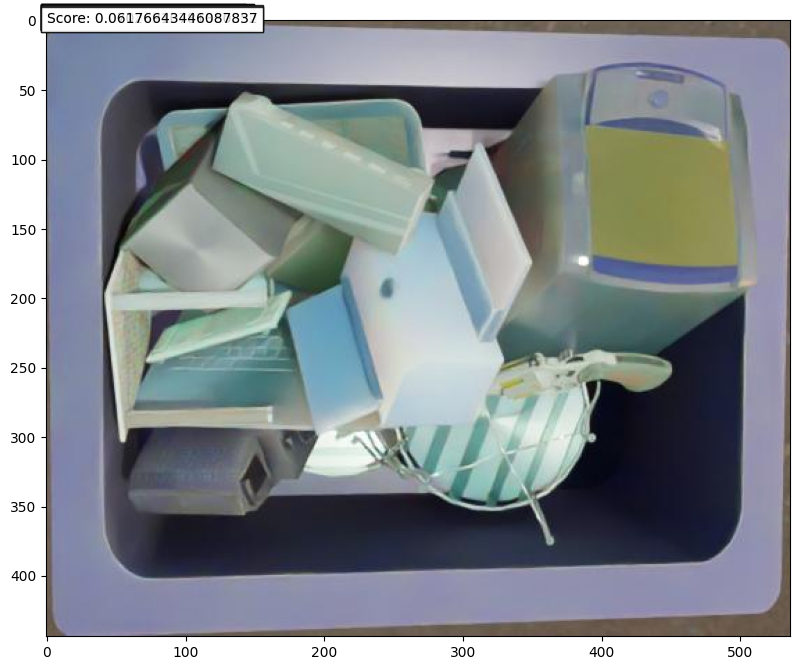

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img_np = img_for_test.cpu().permute(1, 2, 0).numpy()
scores = pred[0]['scores']

# We get the filtered boxes based on scores, and then we output them
filtered_indices = scores > 0.05
filtered_boxes = pred[0]['boxes'][filtered_indices]
filtered_scores = pred[0]['scores'][filtered_indices]

fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(img_np)

# We draw bounding boxes with scores
for box, score in zip(filtered_boxes, filtered_scores):
    box_np = box.cpu().numpy()
    rect = patches.Rectangle(
        (box_np[0], box_np[1]),
        box_np[2] - box_np[0],
        box_np[3] - box_np[1],
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)
    ax.text(
        box_np[0],
        box_np[1],
        f'Score: {score}',
        bbox=dict(facecolor='white', alpha=0.8)
    )

plt.show()

Unfortunately our model does not work. Could be the way the data is structured, for eg the bounding boxes, and given the the time constraint Im able to generate it till here

Optional Task - Convert to ONNX Model

In [ ]:
import torch.onnx

model.eval()
dummy_input = torch.randn(2, *img_for_test.shape)

# We will export to ONNX
torch.onnx.export(model, dummy_input, "model.onnx",
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})